## `Speculator`

`speculator` takes physical parameters and predict PCA coeffs, spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi
import torch

In [3]:
from torch import Tensor

In [4]:
kuaizi.set_matplotlib(style='nature', usetex=False)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [5]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [21]:
speculator = Speculator(n_parameters=2,
                        pca_filename='./train_sed/pca_trained.pkl', 
                        hidden_size=[256, 256, 256])

In [22]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
# This zero_flag is SUPER IMPORTANT!!!

log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
pca_coeff = np.load('./train_sed/pca_coeffs.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

`params: stellar mass, tau, log_age`

In [23]:
speculator.load_data(pca_coeff, params, val_frac=0.1, batch_size=128, 
                        wave_rest=torch.arange(3000, 11000, 2), 
                        wave_obs=torch.arange(3000, 11000, 2))

train_ind = speculator.dataloaders['train'].dataset.indices
val_ind = speculator.dataloaders['val'].dataset.indices

In [24]:
%%time
n_ep = [200, 100, 150, 500]
for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4]):
    speculator.train(learning_rate=lr, n_epochs=n_ep[i])

Epoch: 0 - train Loss: 0.0080
Epoch: 0 - val Loss: 0.0778
Epoch: 100 - train Loss: 0.0011
Epoch: 100 - val Loss: 0.0105
Epoch: 0 - train Loss: 0.0007
Epoch: 0 - val Loss: 0.0069
Epoch: 0 - train Loss: 0.0003
Epoch: 0 - val Loss: 0.0035
Epoch: 100 - train Loss: 0.0002
Epoch: 100 - val Loss: 0.0016
Epoch: 0 - train Loss: 0.0002
Epoch: 0 - val Loss: 0.0017
Epoch: 100 - train Loss: 0.0001
Epoch: 100 - val Loss: 0.0013
Epoch: 200 - train Loss: 0.0001
Epoch: 200 - val Loss: 0.0012
Epoch: 300 - train Loss: 0.0001
Epoch: 300 - val Loss: 0.0012
Epoch: 400 - train Loss: 0.0001
Epoch: 400 - val Loss: 0.0011
CPU times: user 55.1 s, sys: 5.58 s, total: 1min
Wall time: 1min 4s


In [25]:
# %%time
# # n_ep = [100, 100, 150, 500, 500]
# # for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 1e-4]):
# n_ep = [200, 200, 200, 200, 200]
# for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 2e-4]):
#     speculator.train(learning_rate=lr, n_epochs=n_ep[i])

In [27]:
speculator.best_recon_err_epoch

457

In [28]:
speculator.best_loss_epoch

498

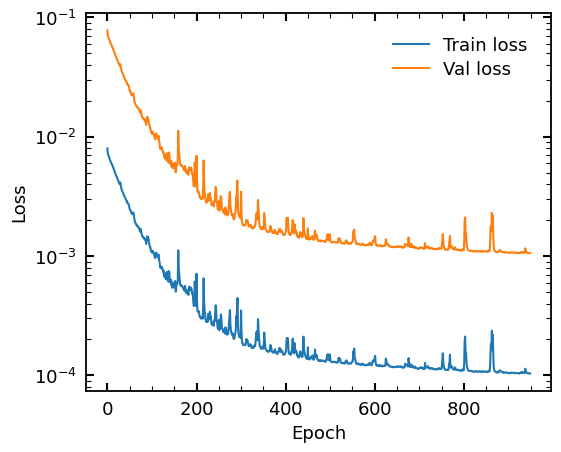

In [29]:
speculator.plot_loss()

In [54]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [55]:
_specs = speculator.predict_spec(params).cpu().detach().numpy()

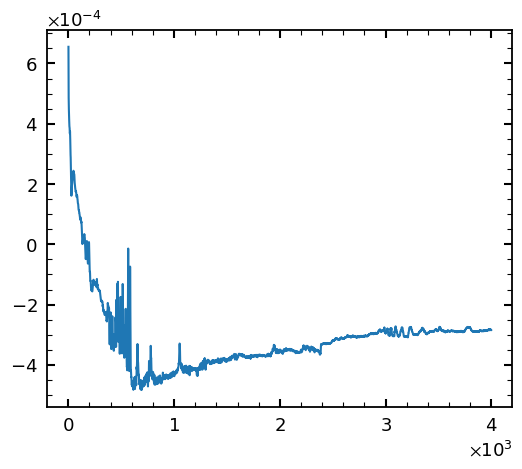

In [56]:
plt.plot(np.median(np.log10(_specs) - log_spec_all, axis=0))

In [57]:
diff = (10**log_spec_all - _specs) / 10**log_spec_all * 100
diff = diff[val_ind]

In [58]:
from scipy.stats import norm

(300.0, 1000.0)

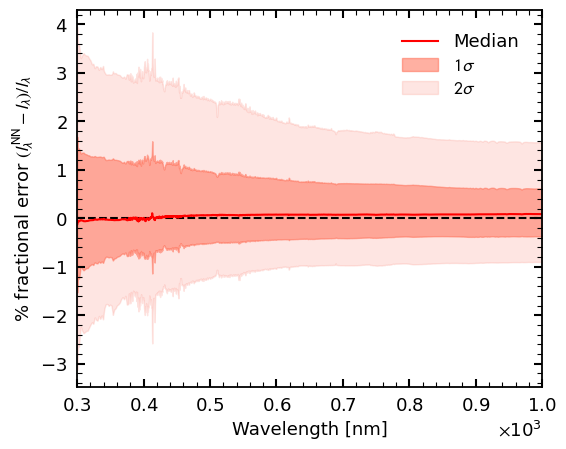

In [59]:
x = np.arange(3000, 11000, 2) / 10
plt.plot(x, np.median(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 300, 1000, ls='--', color='k')
plt.legend()

plt.xlim(300, 1000)

In [60]:
val_ind[20]

1335

Text(0, 0.5, 'Flux Density (normalized to 1 $M_\\odot$)')

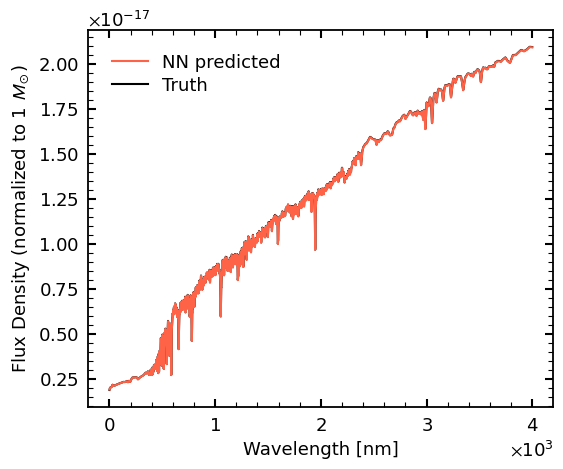

In [61]:
plt.plot(_specs[1335], label='NN predicted', alpha=1, color='tomato', zorder=3)
plt.plot(10**log_spec_all[1335], label='Truth', alpha=1, color='k')

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel(r'Flux Density (normalized to 1 $M_\odot$)')

### From spectrum to magnitudes

Interpolate transmission curves to `self.transmission_effiency`, then integrate over spectrum 

In [62]:
# SDSS
_mag = speculator.predict_mag(params, 
                              stellar_mass=None,#np.ones(5) * 1e10,
                              redshift=None,#np.linspace(0, 0, 5),
                             filterset=['sdss_{0}0'.format(b) for b in 'ugriz'])

In [63]:
phot_all = np.load('./train_sed/phot_all.npy')[~zero_flag]
mag = -2.5 * np.log10(phot_all)

In [64]:
diff = (mag - _mag.cpu().detach().numpy()) / mag * 100
diff = diff[val_ind]

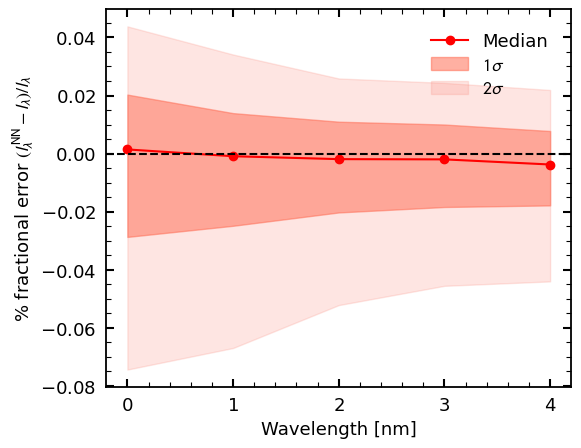

In [65]:
x = [0, 1, 2, 3, 4]
plt.plot(x, np.median(diff, axis=0), marker='o', color='r', label='Median')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.axhline(0, color='k', ls='--')
plt.legend()
